## Dependencies Installation

In [2]:
!pip install google-cloud-aiplatform==1.26.1 -q
# Install Document AI
!pip install google-cloud-documentai==2.16.0 -q
# Install ScANN
!pip install scann==1.2.9 -q
# Install LangChain
!pip install langchain==0.0.214 -q
# Install PDF Reader, Pillow, and Gradio
!pip install pypdf==3.11.0 -q
!pip install gradio==3.35.2 -q
!pip install matplotlib==3.7.1 -q
!pip install shapely==1.8.5
!pip install Pillow==9.5.0

DEPRECATION: textract 1.6.5 has a non-standard dependency specifier extract-msg<=0.29.*. pip 23.3 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of textract or contact the author to suggest that they release a version with a conforming dependency specifiers. Discussion can be found at https://github.com/pypa/pip/issues/12063
DEPRECATION: textract 1.6.5 has a non-standard dependency specifier extract-msg<=0.29.*. pip 23.3 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of textract or contact the author to suggest that they release a version with a conforming dependency specifiers. Discussion can be found at https://github.com/pypa/pip/issues/12063
DEPRECATION: textract 1.6.5 has a non-standard dependency specifier extract-msg<=0.29.*. pip 23.3 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of textract or contact the author to suggest that they release a v

---

#### ⚠️ Do not forget to click the "RESTART RUNTIME" button above.
1. Reinitialize your project variables that you specified in the Initialize environment section.

2. You can skip directly to the Import packages section afterwards.

## Prerequisites
1. Set the environment variables
2. Create a bucket and upload your pdf to the bucket
   
(In this notebook the document has challenges when the number of pages > 110, so I only used the first 100 pages)


In [12]:
PROJECT_ID = "providersearch-378121"
REGION = "us-central1"
SIGNING_SERVICE_ACCOUNT = "45732492323-compute@developer.gserviceaccount.com"

In [13]:
import concurrent.futures
import datetime
import gradio as gr
import IPython
import numpy as np
import os
import pandas as pd
import PIL, PIL.ImageDraw
import requests
import scann
import shapely
import time
import tempfile
import threading
import vertexai
from io import BytesIO
from google.api_core.client_options import ClientOptions
from google.auth import default
from google.auth import impersonated_credentials
from google.cloud import documentai, storage

from langchain.chains.question_answering import load_qa_chain
from langchain.docstore.document import Document
from langchain.document_loaders.base import BaseLoader
from langchain.document_loaders.unstructured import UnstructuredFileLoader
from langchain.embeddings.base import Embeddings
from langchain.embeddings import VertexAIEmbeddings
from langchain.llms import BaseLLM, VertexAI
from langchain.prompts import PromptTemplate
from langchain.schema import Document
from langchain.vectorstores.base import VectorStore
from langchain.vectorstores import MatchingEngine
from pypdf import PdfReader, PdfWriter
from tqdm import tqdm
from typing import Any, Iterable, List, Optional, Sequence, Tuple, Type
from urllib.parse import urlparse

vertexai.init(project=PROJECT_ID, location=REGION)
print("Done")

Done


## Code Dependencies

In [14]:
class SourceDocument:
    """Document Metadata for DocAILoader"""

    def __init__(self, content: Optional[bytes], mime_type: str, source: str, page: Optional[int] = None, **kwargs):
        """Initialize with content, mime type, source, and optional page"""
        super().__init__(**kwargs)
        self.content = content
        self.mime_type = mime_type
        self.source = source
        self.page = page
        self.document = None

    def set_document(self, document: documentai.Document) -> None:
        self.content = None
        self.document = document

class DocAILoader(BaseLoader):
    """Loading logic for loading documents from GCS."""

    def __init__(
        self,
        sources: List[str],
        project_id: str,
        location: str = "us",
        processor_id: str = None,
        default_processor_display_name: str = "doc-search-form-parser",
        default_processor_type: str = "FORM_PARSER_PROCESSOR",
        default_processor_version: str = "pretrained-form-parser-v1.0-2020-09-23",
        create_processor_if_not_exists: bool = True,
        max_doc_ai_requests_per_min: int = 96,
        max_parallel_doc_ai_requests: int = 8,
        verbose: bool = True
    ) -> None:
      """
      Initialize

      Args:
        sources (List[str]): List of source documents
        project_id (str): Project ID
        location (str): Location of the project
        processor_id (str): Processor ID
        default_processor_display_name (str): Default processor display name
        default_processor_type (str): Default processor type
        default_processor_version (str): Default processor version
        create_processor_if_not_exists (bool): Create processor if it does not exist
        max_doc_ai_requests_per_min (int): Max parallel document AI requests
        max_parallel_doc_ai_requests (int): Max parallel document AI requests
        verbose (bool): Verbose
      Returns:
        None
      """
      self.sources = sources
      self.project_id = project_id
      self.location = location
      self.processor_id = processor_id
      self.default_processor_display_name = default_processor_display_name
      self.default_processor_type = default_processor_type
      self.default_processor_version = default_processor_version
      self.create_processor_if_not_exists = create_processor_if_not_exists
      self.max_doc_ai_requests_per_min = max_doc_ai_requests_per_min
      self.max_parallel_doc_ai_requests = max_parallel_doc_ai_requests
      self.verbose = verbose
      self.processor_name = None
      self.doc_ai_api_calls = np.array([])
      self.active_calls = 0
      self.lock = threading.Lock()

    def set_processor(self) -> None:
      """
      Set processor

      Args:
        processor_id (str): Processor ID

      Returns:
        None
      """

      if self.processor_id is None:
        opts = ClientOptions(api_endpoint=f"{self.location}-documentai.googleapis.com")
        client = documentai.DocumentProcessorServiceClient(client_options=opts)
        parent = client.common_location_path(self.project_id, self.location)

        self.processor_name = None
        # check if processor already exists
        processor_list = client.list_processors(parent=parent)
        for processor in processor_list:
          if processor.display_name == self.default_processor_display_name:
            self.processor_name = processor.name
            if self.verbose is True:
              print(f'Set processor "{self.processor_name}" ✓')
            break

        if self.processor_name is None and self.create_processor_if_not_exists:
          if self.verbose is True:
            print(f'Creating new processor of type "{self.default_processor_type}"' +
                  f' with display name "{self.default_processor_display_name}"...')
          # create a processor
          processor = client.create_processor(
            parent=parent,
            processor=documentai.Processor(
                display_name=self.default_processor_display_name,
                type_=self.default_processor_type,
                default_processor_version=self.default_processor_version
            ),
          )
          self.processor_name = processor.name
          if self.verbose is True:
            print(f'Created and set processor "{self.processor_name}" ✓')
      else:
        self.processor_name = (
            f"projects/{self.project_id}/locations/{self.location}/processors/{self.processor_id}"
        )

    def _process_gcs_uri(self, uri: str) -> Sequence[str]:
      """
      Deconstruct GCS URI into scheme, bucket, path and file

      Args:
          uri (str): GCS URI

      Returns:
          scheme (str): URI scheme
          bucket (str): URI bucket
          path (str): URI path
          filename (str): URI file
      """
      url_arr = uri.split("/")
      if "." not in url_arr[-1]:
          filename = ""
      else:
          filename = url_arr.pop()
      scheme = url_arr[0]
      bucket = url_arr[2]
      path = "/".join(url_arr[3:])
      path = path[:-1] if path.endswith("/") else path
      return scheme, bucket, path, filename

    def _is_url(self, string):
      parsed = urlparse(string)
      return parsed.scheme and parsed.netloc

    def _get_mime_type(self, filename: str):
      """
      Get MIME type

      Args:
        filename (str): URI or file name.

      Returns:
        mime_type (str)
      """
      mime_type = 'application/pdf'
      if filename.lower().endswith("pdf"):
          mime_type = "application/pdf"
      elif filename.lower().endswith("tiff") or filename.endswith("tif"):
          mime_type = "image/tiff"
      elif filename.lower().endswith("jpeg") or filename.lower().endswith("jpg"):
          mime_type = "image/jpeg"
      elif filename.lower().endswith("png"):
          mime_type = "image/png"
      elif filename.lower().endswith("bmp"):
          mime_type = "image/bmp"
      elif filename.lower().endswith("webp"):
          mime_type = "image/webp"

      return mime_type

    def _get_docs_from_sources(self, sources: Sequence[str]):
      """
      Get docs from sources

      Args:
        sources (Sequence[str]): List of GCS URIs and website URLs

      Returns:
        docs (List[Document]): SourceDocuments
      """

      # initialize storage client
      storage_client = storage.Client()

      docs = []
      for source in sources:
          if source.startswith('gs://'):
              scheme, bucket, path, filename = self._process_gcs_uri(source)
              # create a bucket object for our bucket
              bucket = storage_client.get_bucket(bucket)
              # create a blob object from the filepath
              blob = bucket.blob(os.path.join(path, filename))

              if blob.exists():
                # get content bytes
                content = blob.download_as_bytes()
                if blob.content_type == "application/pdf":
                  pdf_reader = PdfReader(BytesIO(content))
                  for index, page in enumerate(pdf_reader.pages):
                    pdf_writer = PdfWriter()
                    pdf_writer.add_page(page)
                    response_bytes_stream = BytesIO()
                    pdf_writer.write(response_bytes_stream)
                    content = response_bytes_stream.getvalue()

                    # define source document
                    doc = SourceDocument(content=content, mime_type=blob.content_type, source=source, page=index + 1)
                    docs.append(doc)
                else:
                  # define source document
                  doc = SourceDocument(content=content, mime_type=blob.content_type, source=source)
                  docs.append(doc)

              else:
                raise ValueError(f'Source "{source}" does not exist.')

          elif self._is_url(source):
            # fetch content
            content = requests.get(source).content

            # get mime type
            mime_type = self._get_mime_type(source)

            if mime_type == "application/pdf":
              pdf_reader = PdfReader(BytesIO(content))
              for index, page in enumerate(pdf_reader.pages):
                pdf_writer = PdfWriter()
                pdf_writer.add_page(page)
                response_bytes_stream = BytesIO()
                pdf_writer.write(response_bytes_stream)
                content = response_bytes_stream.getvalue()

                # define source document
                doc = SourceDocument(content=content, mime_type=mime_type, source=source, page=index + 1)
                docs.append(doc)
            else:
              # define source document
              doc = SourceDocument(content=content, mime_type=mime_type, source=source)
              docs.append(doc)
          else:
              raise ValueError(f'Source "{source}" is not valid.')

      return docs

    def _process_doc_rate_limiter(self) -> None:
      """Process doc rate limiter"""
      import math

      # ensure thread safety
      with self.lock:
          current_time = time.time()
          last_minute_calls = self.doc_ai_api_calls[self.doc_ai_api_calls >= current_time - 60]

          # check the number of API calls within the sliding window
          while len(last_minute_calls) >= self.max_doc_ai_requests_per_min:
              # wait_time = last_minute_calls[-1] + 60 - current_time
              wait_time = last_minute_calls[math.ceil((len(last_minute_calls) - 1) / 2)] + 60 - current_time
              time.sleep(wait_time)

          while self.active_calls >= self.max_parallel_doc_ai_requests:
              time.sleep(.5)

          # add the current timestamp to the list of API calls
          self.active_calls += 1
          current_time = time.time()
          self.doc_ai_api_calls = np.append(self.doc_ai_api_calls, current_time)

    def process_doc(self, doc: SourceDocument) -> documentai.Document:
      """
      Process doc

      Args:
        doc (SourceDocument): SourceDocument

      Returns:
        result.document (documentai.Document)
      """
      # Rate limit the API calls
      self._process_doc_rate_limiter()

      # initialize Document AI client
      opts = ClientOptions(api_endpoint=f"{self.location}-documentai.googleapis.com")
      client = documentai.DocumentProcessorServiceClient(client_options=opts)

      # configure the process request
      raw_document = documentai.RawDocument(content=doc.content, mime_type=doc.mime_type)
      processor_version_name = os.path.join(self.processor_name, "processorVersions", self.default_processor_version)
      request = documentai.ProcessRequest(name=processor_version_name, raw_document=raw_document)

      # process the document
      # For a full list of `Document` object attributes, reference this page:
      # https://cloud.google.com/document-ai/docs/reference/rest/v1/Document
      result = client.process_document(request=request)

      return result.document

    def _process_sources(self, max_workers: Optional[int] = None) -> List[SourceDocument]:
      """
      Process sources

      Args:
        max_workers (Optional[int], optional): Maximum number of workers. Defaults to None.

      Returns:
        results (List[documentai.Document]): Documents
      """
      # get docs
      docs = self._get_docs_from_sources(self.sources)

      # initialize empty results
      results = [None] * len(docs)

      if not max_workers:
          max_workers = len(docs)

      # create thread pool with a max number of workers
      start_time = time.time()
      with concurrent.futures.ThreadPoolExecutor(max_workers=max_workers) as executor:
          # submit each doc processing task to the thread pool
          future_to_doc = {executor.submit(self.process_doc, doc): (index, doc) for index, doc in enumerate(docs)}

          # Use tqdm to create a progress bar
          with tqdm(total=len(future_to_doc), position=0, leave=True) as progress_bar:

            # process the completed tasks as they finish
            for future in concurrent.futures.as_completed(future_to_doc):
                index, doc = future_to_doc[future]
                doc.set_document(future.result())
                results[index] = doc
                self.active_calls -= 1
                # update the progress bar
                progress_bar.update(1)

      end_time = time.time()
      time_lapse = end_time - start_time
      time_lapse_mins = round(time_lapse / 60, 3)
      if self.verbose is True:
        print(f'Processed {len(sources)} source(s) and got {len(results)} result(s) in {time_lapse_mins} mins.  ✓')

      return results

    def load(self, max_workers: Optional[int] = None) -> Tuple[List[Document], dict[Tuple[str, str]: bytes]]:
      """
      Load documents

      Args:
        max_workers (Optional[int], optional): Maximum number of workers. Defaults to None.

      Returns:
        documents (List[Document]): Documents
        images (dict[Tuple[str, str]]: bytes]): Images
      """
      self.set_processor()

      # get results
      results = self._process_sources(max_workers=max_workers)

      documents = []
      images = {}
      for result in results:

        images.setdefault((result.source, result.page), result.document.pages[0].image.content)

        # create documents from detected tables on page
        table_documents = []
        for table_index, detected_table in enumerate(result.document.pages[0].tables):
            text_segments = []
            for text_segment in detected_table.layout.text_anchor.text_segments:
              text_segments.append({"start_index": text_segment.start_index, "end_index": text_segment.end_index})
            text_segments_df = pd.DataFrame(text_segments)
            text_segments_df.sort_values(["start_index"], inplace=True)
            text_segments_df["text"] = text_segments_df.apply(lambda x: result.document.text[x.start_index: x.end_index], axis=1)

            vertices = []
            for vertex in detected_table.layout.bounding_poly.vertices:
              vertices.append({"x": vertex.x, "y": vertex.y})

            document = Document(
                page_content='\n'.join(text_segments_df["text"]),
                metadata={
                    "page": result.page,
                    "table": table_index + 1,
                    "mime_type": result.mime_type,
                    "source": result.source,
                    "vertices": vertices
                }
            )
            table_documents.append(document)

        documents.extend(table_documents)

        # create documents from detected blocks on page
        for block_index, detected_block in enumerate(result.document.pages[0].blocks):
            text_segments = []
            for text_segment in detected_block.layout.text_anchor.text_segments:
              text_segments.append({"start_index": text_segment.start_index, "end_index": text_segment.end_index})
            text_segments_df = pd.DataFrame(text_segments)
            text_segments_df.sort_values(["start_index"], inplace=True)
            text_segments_df["text"] = text_segments_df.apply(lambda x: result.document.text[x.start_index: x.end_index], axis=1)

            vertices = []
            for vertex in detected_block.layout.bounding_poly.vertices:
              vertices.append({"x": vertex.x, "y": vertex.y})
            block_shape = shapely.geometry.Polygon([(vertex['x'], vertex['y']) for vertex in vertices])

            # only use blocks that are not within table boundaries
            add_block = True
            for table_document in table_documents:
              table_shape = shapely.geometry.Polygon([(vertex['x'], vertex['y']) for vertex in table_document.metadata["vertices"]])
              if block_shape.intersects(table_shape):
                add_block = False

            if add_block:
              document = Document(
                  page_content=''.join(text_segments_df["text"]),
                  metadata={
                      "page": result.page,
                      "block": block_index + 1,
                      "mime_type": result.mime_type,
                      "source": result.source,
                      "vertices": vertices
                  }
              )
              documents.append(document)

      if self.verbose is True:
        print(f'Loaded {len(documents)} document(s) and {len(images)} image(s)  ✓')

      return documents, images

class ScaNN(VectorStore):
    """
    This class is a wrapper around the ScaNN Vector Similarity Search library.

    To use, you should have the ``scann`` python package installed.

    References:

    https://github.com/google-research/google-research/tree/master/scann
    """

    def __init__(
        self,
        embedding_function: Optional[Embeddings] = None,
        max_embedding_requests_per_min: int = 300,
        verbose: bool = True
    ) -> None:
        """Initialize the ScaNN vector store"""
        if embedding_function is None:
          embedding_function = VertexAIEmbeddings()
        self._embedding_function = embedding_function
        self._searcher = None
        self.max_embedding_requests_per_min = max_embedding_requests_per_min
        self.verbose = verbose
        self.embedding_api_calls = np.array([])
        self.lock = threading.Lock()

    def _embedding_rate_limiter(self) -> None:
      """Embedding rate limiter"""

      # ensure thread safety
      with self.lock:
          current_time = time.time()

          self.embedding_api_calls = self.embedding_api_calls[self.embedding_api_calls >= current_time - 60]

          # check the number of API calls within the sliding window
          if len(self.embedding_api_calls) >= self.max_embedding_requests_per_min:
              # if the limit is reached, calculate the remaining time until the next API call is allowed
              next_call_time = self.embedding_api_calls[0] + 60
              wait_time = next_call_time - current_time
              if wait_time > 0:
                  time.sleep(wait_time)

          # add the current timestamp to the list of API calls
          self.embedding_api_calls = np.append(self.embedding_api_calls, current_time)

    def _embed_query(self, query: str, index: Optional[int] = None) -> List:
      """
      Embed query

      Args:
        query (str): Query to embed
        index (Optional[int]): Index of the query

      Returns:
        index (Optional[int]): Index of the query
        embeddings (List): Embeddings
      """
      self._embedding_rate_limiter()
      embedding = self._embedding_function.embed_query(query)
      return index, embedding

    def embed_texts(self, texts: List[str], max_workers: Optional[int] = None) -> List[list]:
      """
      Embed texts

      Args:
        texts (List[str]): Texts to embed
        max_workers (Optional[int]): Maximum number of workers to use

      Returns:
        results (List[list]): Embeddings
      """
      # initialize empty results
      results = [None] * len(texts)

      if not max_workers:
          max_workers = len(texts)

      # create thread pool with a max number of workers
      start_time = time.time()
      with concurrent.futures.ThreadPoolExecutor(max_workers=max_workers) as executor:
          # submit each doc processing task to the thread pool
          futures = [executor.submit(self._embed_query, text, index) for index, text in enumerate(texts)]

          # Use tqdm to create a progress bar
          with tqdm(total=len(futures), position=0, leave=True) as progress_bar:

            # process the completed tasks as they finish
            for future in concurrent.futures.as_completed(futures):
                index, embedding = future.result()
                results[index] = embedding

                # update the progress bar
                progress_bar.update(1)

      end_time = time.time()
      time_lapse = end_time - start_time
      time_lapse_mins = round(time_lapse / 60, 3)

      if self.verbose is True:
        print(f'Embedded {len(documents)} documents(s) in {time_lapse_mins} mins. ✓')

      return results

    def add_texts(
        self,
        texts: Iterable[str],
        num_neighbors: int = 10,
        distance_function: str = "dot_product",
        num_leaves: Optional[int] = None,
        num_leaves_to_search: Optional[int] = None,
        training_sample_size: Optional[int] = None,
        dimensions_per_block: int = 2,
        anisotropic_quantization_th: Optional[float] = 0.2,
        reorder_count: Optional[int] = None,
        **kwargs: Any,
    ) -> List[str]:
        """
        Generate embeddings and add to the vectorstore

        Args:
            texts (Iterable[str]): Texts to add to the vectorstore.
            num_neighbors (int, optional): Number of neighbors to consider during partitioning. Defaults to 10.
            distance_function (str): Distance function to use. Defaults to "dot_product".
            num_leaves (Optional[int], optional): Number of leaves to search. Defaults to None.
            num_leaves_to_search (Optional[int], optional): Number of leaves to search. Defaults to None.
            training_sample_size (Optional[int], optional): Number of documents to use for training. Defaults to None.
            dimensions_per_block (int, optional): Number of dimensions per block. Defaults to 2.
            anisotropic_quantization_th (Optional[float], optional): Anisotropic quantization threshold. Defaults to 0.2.
            reorder_count (Optional[int], optional): Number of reorders to perform. Defaults to None.

        Returns:
            None
        """
        num_texts = len(texts)

        if num_leaves is None:
          num_leaves = num_texts
        if num_leaves_to_search is None:
          num_leaves_to_search = num_texts
        if training_sample_size is None:
          training_sample_size = num_texts
        if reorder_count is None:
          reorder_count = num_texts

        embeddings = self._embedding_function.embed_documents(list(texts))
        embeddings = self.embed_texts(texts)
        normalized_embeddings = embeddings / np.linalg.norm(embeddings, axis=1)[:, np.newaxis]

        # use scann.scann_ops.build() to instead create a TensorFlow-compatible searcher
        self._searcher = (
            scann.scann_ops_pybind.builder(normalized_embeddings, num_neighbors, distance_function)
            .tree(
                num_leaves=num_leaves,
                num_leaves_to_search=num_leaves_to_search,
                training_sample_size=training_sample_size,
            )
            .score_ah(
                dimensions_per_block,
                anisotropic_quantization_threshold=anisotropic_quantization_th)
            .reorder(reorder_count)
            .build()
        )

        if self.verbose is True:
          print("ScaNN vector store is indexed and loaded. ✓")

    @classmethod
    def from_texts(
        cls: Type[VectorStore],
        texts: Iterable[str],
        embedding: Optional[Embeddings] = None,
        max_embedding_requests_per_min: int = 300,
        num_neighbors: int = 10,
        distance_function: str = "dot_product",
        num_leaves: Optional[int] = None,
        num_leaves_to_search: Optional[int] = None,
        training_sample_size: Optional[int] = None,
        dimensions_per_block: int = 2,
        anisotropic_quantization_th: Optional[float] = 0.2,
        reorder_count: Optional[int] = None,
        verbose: bool = True,
        **kwargs: Any,
    ) -> VectorStore:
        """
        Create a ScaNN vector store from a list of texts.

        Args:
            texts (Iterable[str]): Texts to add to the vectorstore.
            embedding (Optional[Embeddings], optional): Embeddings to use for the vectorstore. Defaults to None.
            max_embedding_requests_per_min (int, optional): Maximum number of embedding requests per minute. Defaults to 500.
            num_neighbors (int, optional): Number of neighbors to consider during partitioning. Defaults to 10.
            distance_function (str): Distance function to use. Defaults to "dot_product".
            num_leaves (Optional[int], optional): Number of leaves to search. Defaults to None.
            num_leaves_to_search (Optional[int], optional): Number of leaves to search. Defaults to None.
            training_sample_size (Optional[int], optional): Number of documents to use for training. Defaults to None.
            dimensions_per_block (int, optional): Number of dimensions per block. Defaults to 2.
            anisotropic_quantization_th (Optional[float], optional): Anisotropic quantization threshold. Defaults to 0.2.
            reorder_count (Optional[int], optional): Number of reorders to perform. Defaults to None.
            verbose (bool, optional): Verbosity. Defaults to True.
        Returns:
            scann_store: ScaNN vectorstore.
        """
        # create scann store
        scann_store = cls(
            embedding_function=embedding,
            max_embedding_requests_per_min=max_embedding_requests_per_min,
            verbose=verbose)

        # add texts to scann score
        scann_store.add_texts(
            texts=texts,
            num_neighbors=num_neighbors,
            distance_function=distance_function,
            num_leaves=num_leaves,
            num_leaves_to_search=num_leaves_to_search,
            training_sample_size=training_sample_size,
            dimensions_per_block=dimensions_per_block,
            anisotropic_quantization_th=anisotropic_quantization_th,
            reorder=reorder_count,
        )
        return scann_store


    @classmethod
    def from_documents(
        cls: Type[VectorStore],
        documents: List[Document],
        embedding: Optional[Embeddings] = None,
        max_embedding_requests_per_min: int = 300,
        num_neighbors: int = 10,
        distance_function: str = "dot_product",
        num_leaves: Optional[int] = None,
        num_leaves_to_search: Optional[int] = None,
        training_sample_size: Optional[int] = None,
        dimensions_per_block: int = 2,
        anisotropic_quantization_th: Optional[float] = 0.2,
        reorder_count: Optional[int] = None,
        verbose: bool = True,
        **kwargs: Any,
    ) -> VectorStore:
        """
        Create a ScaNN vector store from a list of documents.

        Args:
            documents (List[Document]): Documents to add to the vectorstore.
            embedding (Optional[Embeddings], optional): Embeddings to use for the vectorstore. Defaults to None.
            max_embedding_requests_per_min (int, optional): Maximum number of embedding requests per minute. Defaults to 500.
            num_neighbors (int, optional): Number of neighbors to consider during partitioning. Defaults to 10.
            distance_function (str): Distance function to use. Defaults to "dot_product".
            num_leaves (Optional[int], optional): Number of leaves to search. Defaults to None.
            num_leaves_to_search (Optional[int], optional): Number of leaves to search. Defaults to None.
            training_sample_size (Optional[int], optional): Number of documents to use for training. Defaults to None.
            dimensions_per_block (int, optional): Number of dimensions per block. Defaults to 2.
            anisotropic_quantization_th (Optional[float], optional): Anisotropic quantization threshold. Defaults to 0.2.
            reorder_count (Optional[int], optional): Number of reorders to perform. Defaults to None.
            verbose (bool, optional): Verbosity. Defaults to True.
        Returns:
            scann_store: ScaNN vectorstore.
        """
        texts = [doc.page_content for doc in documents]
        return cls.from_texts(
            texts=texts,
            embedding=embedding,
            max_embedding_requests_per_min=max_embedding_requests_per_min,
            num_neighbors=num_neighbors,
            distance_function=distance_function,
            num_leaves=num_leaves,
            num_leaves_to_search=num_leaves_to_search,
            training_sample_size=training_sample_size,
            dimensions_per_block=dimensions_per_block,
            anisotropic_quantization_th=anisotropic_quantization_th,
            reorder_count=reorder_count,
            verbose=verbose
        )

    def similarity_search(
        self,
        query: str,
        k: Optional[int] = None,
        **kwargs: Any,
    ) -> List[Document]:
        """
        Run similarity search with ScaNN

        Args:
            query (str): Query text to search for.
            k (Optional[int]): Number of results to return. Defaults to 4.

        Returns:
            List[Document]: List of documents most similar to the query text.
            distances (List[float]): List of distances to the query text.
        """
        query = self._embedding_function.embed_query(query)
        neighbors, distances = self._searcher.search(query, final_num_neighbors=k)
        return neighbors, distances


class DocumentBot:
  """"
  A bot that can answer questions about documents.
  """

  def __init__(
      self,
      documents: List[Document],
      images: dict[Tuple[str, str]: bytes],
      vector_store: VectorStore,
      llm: BaseLLM,
      answer_template: str,
      prompt: Optional[PromptTemplate] = None,
      signed_url_target_scopes: Optional[List[str]] = None,
      signing_service_account: Optional[str] = None,
      signing_service_account_credentials_lifetime: int = 300,
      signed_url_mins_to_expiration: int = 15,
      verbose: bool = True
    ) -> None:
    self.documents = documents
    self.images = images
    self.vector_store = vector_store
    self.llm = llm
    self.answer_template = answer_template
    self.prompt = prompt

    if signed_url_target_scopes is None:
      signed_url_target_scopes = ['https://www.googleapis.com/auth/devstorage.read_only']
    self.signed_url_target_scopes = signed_url_target_scopes
    self.signing_service_account = signing_service_account
    self.signing_service_account_credentials_lifetime = signing_service_account_credentials_lifetime
    self.signed_url_mins_to_expiration = signed_url_mins_to_expiration

    self.verbose = verbose

    self.chain = load_qa_chain(self.llm, chain_type="stuff", prompt=self.prompt)

  def _get_qa_chain_output(self, query) -> Tuple[dict[str: Any], List[float]]:
    """
    Get the output of the QA chain for a given query.

    Args:
        query (str): Query text to search for.

    Returns:
        dict[str: Any]: Output of the QA chain.
        distances (List[float]): List of distances to the query text.
    """
    # get nearest neighbors and distances
    neighbors, distances = vector_store.similarity_search(query, k=5)
    matching_documents = [self.documents[i] for i, distance in zip(neighbors, distances)]
    output = self.chain({"input_documents": matching_documents, "question": query})
    return output, distances

  def _process_gcs_uri(self, uri: str) -> Sequence[str]:
      """
      Deconstruct GCS URI into scheme, bucket, path and file

      Args:
          uri (str): GCS URI

      Returns:
          scheme (str): URI scheme
          bucket (str): URI bucket
          path (str): URI path
          filename (str): URI file
      """
      url_arr = uri.split("/")
      if "." not in url_arr[-1]:
          filename = ""
      else:
          filename = url_arr.pop()
      scheme = url_arr[0]
      bucket = url_arr[2]
      path = "/".join(url_arr[3:])
      path = path[:-1] if path.endswith("/") else path
      return scheme, bucket, path, filename

  def _generate_download_signed_url_v4(
      self,
      bucket_name: str,
      blob_name: str,
      target_credentials: impersonated_credentials.Credentials,
  ) -> str:
    """
    Generates a v4 signed URL for downloading a blob.

    Args:
        bucket_name (str): Bucket name.
        blob_name (str): Blob name.
        target_credentials (impersonated_credentials.Credentials): Target credentials.

    Returns:
        str: Signed URL.
    """
    storage_client = storage.Client()
    bucket = storage_client.bucket(bucket_name)
    blob = bucket.blob(blob_name)

    url = blob.generate_signed_url(
        version="v4",
        expiration=datetime.timedelta(minutes=self.signed_url_mins_to_expiration),
        method="GET",
        credentials=target_credentials
    )

    return url

  def _get_formatted_sources(
      self,
      output,
      distances,
      gradio_format: bool = False,
      serve_signed_urls: bool = True
  ) -> List[str]:
    """
    Format the sources.

    Args:
        output (dict[str: Any]): Output of the QA chain.

    Returns:
        List[str]
    """
    # initialize empty formatted sources
    formatted_sources = []

    # get credentials
    credentials, _ = default()

    # get target credentials
    target_credentials = impersonated_credentials.Credentials(
        source_credentials=credentials,
        target_principal=self.signing_service_account,
        target_scopes=self.signed_url_target_scopes,
        lifetime=self.signing_service_account_credentials_lifetime
    )

    for index, input_document in enumerate(output["input_documents"]):
      page_number = input_document.metadata["page"]
      source = input_document.metadata["source"]
      source = f'{source}#page={page_number}' if page_number else source
      signed_url = source

      # if GCS URI, get signed url
      if source.startswith("gs://") and serve_signed_urls:
        scheme, bucket_name, path, filename = self._process_gcs_uri(input_document.metadata["source"])

        signed_url = self._generate_download_signed_url_v4(
            bucket_name=bucket_name,
            blob_name=os.path.join(path, filename),
            target_credentials=target_credentials,
        )
        signed_url += f"#page={page_number}" if page_number else signed_url


      similarity = distances[index]
      if index == 0 and not gradio_format:
        top_reference = "* page: {page}, relevance to answer: {similarity:.2f}\n"
        top_reference += "* [{source}]({signed_url})"
        top_reference = top_reference.format(
          page=page_number,
          source=source,
          signed_url=signed_url,
          similarity=similarity
        )
        formatted_sources.append(top_reference)

      if gradio_format:
        reference = '<p><b>{index}</b>. <a href="{signed_url}">{source}</a>, relevance to question: {similarity:.2f}</p>'
        reference = reference.format(
          index=index + 1,
          source=source,
          signed_url=signed_url,
          similarity=similarity
        )
      else:
        reference = "* [{source}]({signed_url})\n\t* page: {page}, relevance to question: {similarity:.2f}"
        reference = reference.format(
            page=page_number,
            source=source,
            signed_url=signed_url,
            similarity=similarity
        )
      formatted_sources.append(reference)

    return formatted_sources


  def answer(self, query: str, serve_signed_urls: bool = False) -> None:
    """
    Get Answer from QA chain.

    Args:
        query (str): Query text to search for.
        serve_signed_urls (bool): Whether to serve signed urls.

    Returns:
      output (dict[str: Any]): Output of the QA chain.
    """
    output, distances = self._get_qa_chain_output(query)
    answer = output["output_text"]
    output, distances = self._get_qa_chain_output(answer)

    if self.verbose is True:
      # get formatted sources
      formatted_sources = self._get_formatted_sources(
          output, distances,
          serve_signed_urls=serve_signed_urls
      )

      # format answer
      answer_str = self.answer_template.format(
          question=query,
          output_text=answer,
          top_reference=formatted_sources[0],
          sources='\n'.join(formatted_sources[1:])
      )

      # display answer
      IPython.display.display(IPython.display.Markdown(answer_str))

      # display image
      top_source = output["input_documents"][0].metadata["source"]
      top_page = output["input_documents"][0].metadata["page"]
      top_vertices = output["input_documents"][0].metadata["vertices"]
      top_vertices = pd.DataFrame(top_vertices).stack().values.tolist()
      image = PIL.Image.open(BytesIO(self.images[(top_source, top_page)]))
      PIL.ImageDraw.Draw(image).polygon(top_vertices, outline = 'green', width=5)
      IPython.display.display(image.resize((800, 1000)))
    return output


  def gradio_answer(self, query: str, serve_signed_urls: bool = False) -> None:
    """
    Get answer formatted for gradio

    Args:
        query (str): Query text to search for.
        serve_signed_urls (bool): Whether to serve signed urls.

    Returns:
      output (dict[str: Any]): Output of the QA chain.
    """
    output, distances = self._get_qa_chain_output(query)
    answer = output["output_text"]
    output, distances = self._get_qa_chain_output(answer)

    # get formatted sources
    formatted_sources = self._get_formatted_sources(
        output, distances,
        gradio_format=True,
        serve_signed_urls=serve_signed_urls
    )
    formatted_sources = '</br>'.join(formatted_sources)
    top_source = output["input_documents"][0].metadata["source"]
    top_page = output["input_documents"][0].metadata["page"]
    top_vertices = output["input_documents"][0].metadata["vertices"]
    top_vertices = pd.DataFrame(top_vertices).stack().values.tolist()
    image = PIL.Image.open(BytesIO(self.images[(top_source, top_page)]))
    PIL.ImageDraw.Draw(image).polygon(top_vertices, outline = 'green', width=5)
    return answer, image, formatted_sources, round(distances[0], 3)



In [15]:
sources = [
    "gs://rk_bestow/ehr-scrubbed-1.pdf"
]

In [16]:
docai_loader = DocAILoader(sources=sources, project_id=PROJECT_ID, max_doc_ai_requests_per_min=110)
documents, images = docai_loader.load()

Set processor "projects/9057658179/locations/us/processors/1a7aae57b0815a7d" ✓


100%|██████████| 100/100 [00:46<00:00,  2.15it/s]


Processed 1 source(s) and got 100 result(s) in 0.776 mins.  ✓
Loaded 926 document(s) and 100 image(s)  ✓


## Create a vector store 
### ScaNN (option 1)
### Google Matching Engine is another option (tbd)

In [17]:
vector_store = ScaNN.from_documents(documents)

100%|██████████| 926/926 [02:57<00:00,  5.20it/s] 


Embedded 926 documents(s) in 3.006 mins. ✓
ScaNN vector store is indexed and loaded. ✓


2023-09-11 23:33:41.311225: I scann/partitioning/partitioner_factory_base.cc:59] Size of sampled dataset for training partition: 926
2023-09-11 23:33:41.654029: I ./scann/partitioning/kmeans_tree_partitioner_utils.h:88] PartitionerFactory ran in 342.577494ms.


## Perform Retrieval QA

Define the following:
* Prompt template
* LLM Model
* Answer template

In [18]:
# LLM model
#model_name = "text-bison@001" #@param {type: "string"}
model_name = "text-bison-32k" #@param {type: "string"}
max_output_tokens = 256 #@param {type: "integer"}
temperature = 0.2 #@param {type: "number"}
top_p = 0.8 #@param {type: "number"}
top_k = 40 #@param {type: "number"}
verbose = True #@param {type: "boolean"}
llm = VertexAI(
  model_name=model_name,
  max_output_tokens=max_output_tokens,
  temperature=temperature,
  top_p=top_p,
  top_k=top_k,
  verbose=verbose
)

In [19]:
prompt_template = """\
Give a detailed and comprehensive answer to the question using information from the provided contexts. Be sure to provide all details that a user would like to take action on the answer.

Evaluate which contexts are most relevant and prioritize comprehensively capturing their details in your response.

{context}

Question:
{question}

Helpful Answer and Explanation:
"""
prompt = PromptTemplate(template=prompt_template, input_variables=["context", "question"])

answer_template = """\
## Response
### Question
{question}
### Answer
{output_text}
### Why
{top_reference}

### Sources
{sources}
"""

In [20]:
document_bot = DocumentBot(
  documents=documents,
  images=images,
  vector_store=vector_store,
  llm=llm,
  prompt=prompt,
  answer_template=answer_template,
  signing_service_account=SIGNING_SERVICE_ACCOUNT
)

### Ask a Question


## Response
### Question
Find all the measurements of body weight
### Answer
 The patient's weight has been measured on multiple dates. The most recent measurement was on 06/08/2023, when the patient weighed 199.1 lb. Other recent measurements include:

* 05/19/2023: 200.0 lb
* 02/08/2023: 198.6 lb
* 02/08/2023: 185.0 lb
* 03/30/2022: 185.0 lb
* 03/07/2022: 185.0 lb
* 01/24/2022: 203.0 lb
* 01/07/2022: 203.5 lb
* 01/06/2022: 190.0 lb
* 12/20/2021: 197.3 lb
* 12/03/2021: 190.0
### Why
* page: 53, relevance to answer: 0.87
* [gs://rk_bestow/ehr-scrubbed-1.pdf#page=53](gs://rk_bestow/ehr-scrubbed-1.pdf#page=53)

### Sources
* [gs://rk_bestow/ehr-scrubbed-1.pdf#page=53](gs://rk_bestow/ehr-scrubbed-1.pdf#page=53)
	* page: 53, relevance to question: 0.87
* [gs://rk_bestow/ehr-scrubbed-1.pdf#page=3](gs://rk_bestow/ehr-scrubbed-1.pdf#page=3)
	* page: 3, relevance to question: 0.81
* [gs://rk_bestow/ehr-scrubbed-1.pdf#page=4](gs://rk_bestow/ehr-scrubbed-1.pdf#page=4)
	* page: 4, relevance to question: 0.81
* [gs://rk_bestow/ehr-scrubbed-1.pdf#page=2](gs://rk_bestow/ehr-scrubbed-1.pdf#page=2)
	* page: 2, relevance to question: 0.81
* [gs://rk_bestow/ehr-scrubbed-1.pdf#page=43](gs://rk_bestow/ehr-scrubbed-1.pdf#page=43)
	* page: 43, relevance to question: 0.80


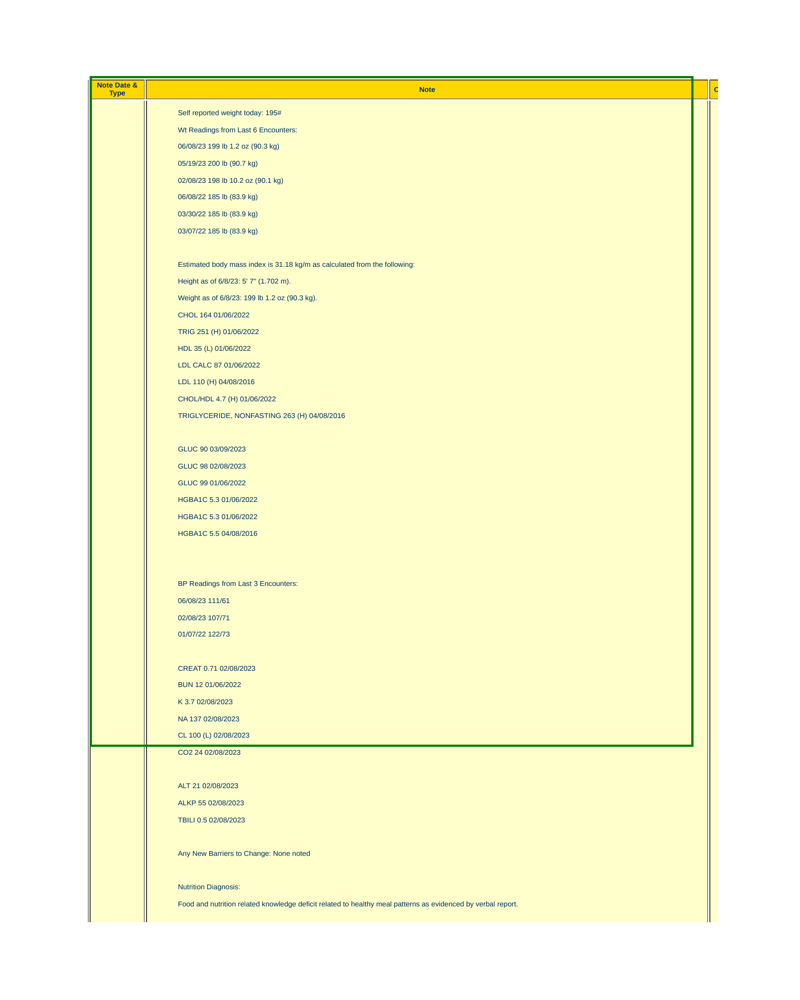

In [17]:
query = "Find all the measurements of body weight" #@param {type:"string"}
_ = document_bot.answer(query, serve_signed_urls=False)

## Response
### Question
What was the maximum body weight noted for the patient
### Answer
 The patient's maximum recorded weight was 205 lbs. 
### Why
* page: 83, relevance to answer: 0.81
* [gs://rk_bestow/ehr-scrubbed-1.pdf#page=83](gs://rk_bestow/ehr-scrubbed-1.pdf#page=83)

### Sources
* [gs://rk_bestow/ehr-scrubbed-1.pdf#page=83](gs://rk_bestow/ehr-scrubbed-1.pdf#page=83)
	* page: 83, relevance to question: 0.81
* [gs://rk_bestow/ehr-scrubbed-1.pdf#page=58](gs://rk_bestow/ehr-scrubbed-1.pdf#page=58)
	* page: 58, relevance to question: 0.74
* [gs://rk_bestow/ehr-scrubbed-1.pdf#page=71](gs://rk_bestow/ehr-scrubbed-1.pdf#page=71)
	* page: 71, relevance to question: 0.74
* [gs://rk_bestow/ehr-scrubbed-1.pdf#page=82](gs://rk_bestow/ehr-scrubbed-1.pdf#page=82)
	* page: 82, relevance to question: 0.73
* [gs://rk_bestow/ehr-scrubbed-1.pdf#page=83](gs://rk_bestow/ehr-scrubbed-1.pdf#page=83)
	* page: 83, relevance to question: 0.73


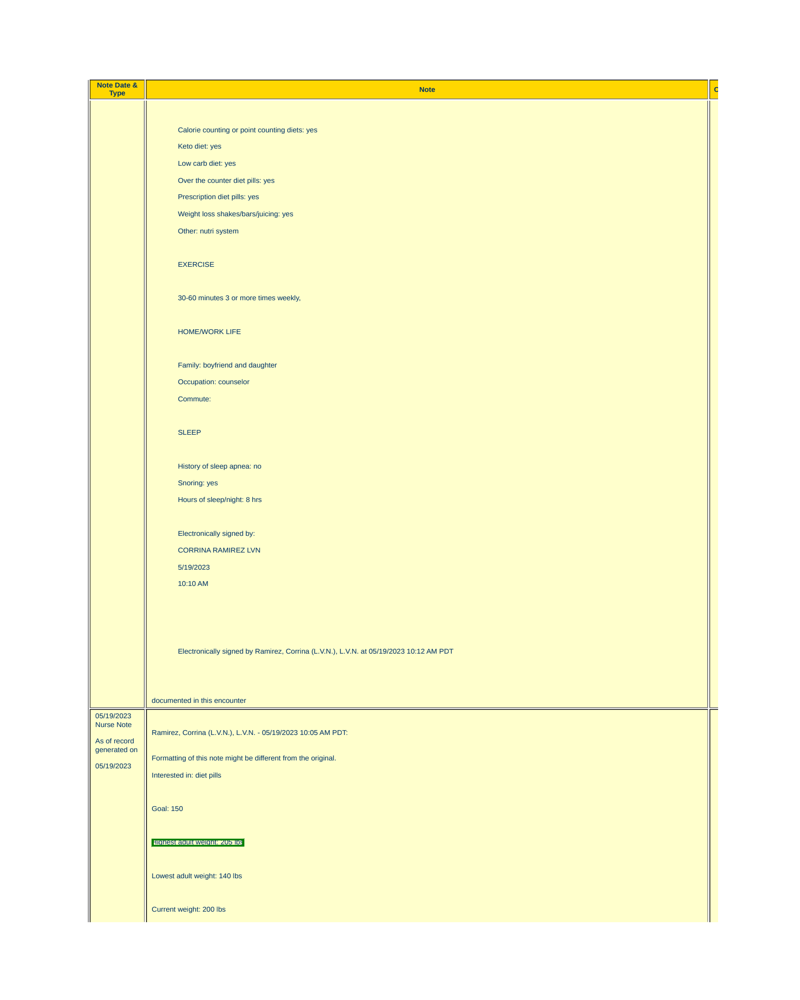

In [21]:
query = "What was the maximum body weight noted for the patient" #@param {type:"string"}
_ = document_bot.answer(query, serve_signed_urls=False)